## Домашнее здание №3 / New Product Forecasting

### Фамилия Имя / Группа

----
План выполнения домашнего задания:

1. Подготовка данных
2. Предсказание без категориальных признаков
3. Предсказание с категориальными признаками
4.  Другие модели и генерация дополнительных признаков
5. Отправка результатов в контест на Kaggle

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from sklearn import tree
from copy import deepcopy
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation
from sklearn.dummy import DummyRegressor
from scipy.optimize import minimize_scalar
from IPython import display
import seaborn as sns
from dateutil import parser
from datetime import datetime
pd.set_option("display.max_columns", 40)
%matplotlib inline

/Users/astepanov/.virtualenvs/tf/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Подготовка данных (1 балл)
 * Изучить признаки
 * Выделить категориальные признаки, которые можно использовать для обучения
 * Выделить датасет только с числовыми признаками
 * Выделить полезные числовые признаки

In [2]:
data = pd.read_csv('./data/train.csv', sep=';', index_col='ID')
data.shape

(40000, 33)

In [3]:
list(zip(data.columns, map(lambda x: data[x].dtype, data.columns)))

[('DEMAND', dtype('float64')),
 ('LOCATION_ID', dtype('int64')),
 ('MODEL_BRAND', dtype('O')),
 ('MODEL_COST_AVG', dtype('float64')),
 ('MODEL_COUNT_SALES_DAYS', dtype('float64')),
 ('MODEL_DIAG', dtype('float64')),
 ('MODEL_DIAG_TYPE', dtype('O')),
 ('MODEL_HEIGHT', dtype('float64')),
 ('MODEL_ID', dtype('int64')),
 ('MODEL_MEAN_SALES', dtype('float64')),
 ('MODEL_NAME', dtype('O')),
 ('MODEL_OS', dtype('O')),
 ('MODEL_RES_TYPE', dtype('O')),
 ('MODEL_TYPE', dtype('O')),
 ('MODEL_WIDTH', dtype('float64')),
 ('STORE_ASSORTMENT', dtype('float64')),
 ('STORE_BRAND_ABC', dtype('O')),
 ('STORE_BRAND_SPECTR', dtype('float64')),
 ('STORE_BUILDING_TYPE', dtype('O')),
 ('STORE_CITY', dtype('O')),
 ('STORE_CLUSTER', dtype('O')),
 ('STORE_DIAG_ABC', dtype('O')),
 ('STORE_DIAG_SPECTR', dtype('float64')),
 ('STORE_FORMAT', dtype('O')),
 ('STORE_OPEN_DTTM', dtype('O')),
 ('STORE_PRICE_TYPE', dtype('O')),
 ('STORE_REGION', dtype('O')),
 ('STORE_RES_ABC', dtype('O')),
 ('STORE_RES_SPECTR', dtype('flo

In [4]:
%cat data/data_description.txt

Данные для прогнозирования интенсивности продаж конкретного товара в конкретной торговой точки розничной сети. 

#	Variable	Description
1	DEMAND            	целевая переменная: интенсивность спроса, расcчитанная на первом месяце истории продаж
2	LOCATION_ID	идентификатор магазина
3	MODEL_BRAND         	бренд модели
4	MODEL_COST_AVG	средняя закупочная стоимость модели в первый месяц продаж
5	MODEL_COUNT_SALES_DAYS             	количество дней, которая модель продавалась в других каналах (связано с MODEL_MEAN_SALES)
6	MODEL_DIAG	длина диагонали
7	MODEL_DIAG_TYPE           	тип диагонали
8	MODEL_HEIGHT	высоты
9	MODEL_ID       	ID модели
10	MODEL_MEAN_SALES	средняя интенсивность продаж модели в других каналах (оценённая на небольшому периоду, см поле MODEL_COUNT_SALES_DAYS)
11	MODEL_NAME	наименование модели
12	MODEL_OS	операционная система
13	MODEL_RES_TYPE	тип разрешения экрана
14	MODEL_TYPE	тип телефона
15	MODEL_WIDTH	ширина экрана
16	STORE_ASSORTMENT	количество моделей в магазине,  на к

In [5]:
data.head(10)

,DEMAND,LOCATION_ID,MODEL_BRAND,MODEL_COST_AVG,MODEL_COUNT_SALES_DAYS,MODEL_DIAG,MODEL_DIAG_TYPE,MODEL_HEIGHT,MODEL_ID,MODEL_MEAN_SALES,MODEL_NAME,MODEL_OS,MODEL_RES_TYPE,MODEL_TYPE,MODEL_WIDTH,STORE_ASSORTMENT,STORE_BRAND_ABC,STORE_BRAND_SPECTR,STORE_BUILDING_TYPE,STORE_CITY,STORE_CLUSTER,STORE_DIAG_ABC,STORE_DIAG_SPECTR,STORE_FORMAT,STORE_OPEN_DTTM,STORE_PRICE_TYPE,STORE_REGION,STORE_RES_ABC,STORE_RES_SPECTR,STORE_TYPE_A,STORE_TYPE_B,STORE_TYPE_C,STORE_TYPE_SPECTR
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.105360,1835543262,ark,5179.7500,NaN,5.5,big,720.0,1682,NaN,ark benefit m7,gsm-and,hd,смартфон,1280.0,136.0,A,0.76,торговый центр,санкт-петербург г,u3m3,A,0.78,новый формат,19MAY15:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,B,0.67,0.75,0.25,0.0,3.06
1,0.000100,1972241965,samsung,22015.3300,NaN,5.2,big,1920.0,34706,NaN,samsung a510 galaxy a5 (2016 edition),gsm-and,hd,смартфон,1080.0,70.0,B,0.73,павильон,санкт-петербург г,u1m2,B,0.65,новый формат,20JAN16:00:00:00,розничная цена (северо-запад-днс1),северо-запад,C,0.48,0.00,1.00,0.0,2.51
2,0.000100,2027986985,samsung,15592.5900,NaN,5.0,big,1280.0,2753,NaN,samsung a5,gsm-and,hd,смартфон,1280.0,106.0,A,0.89,капитальное строение,якутск г,тест,A,0.67,новый формат,27APR16:00:00:00,розничная цена (дальний восток-якутск),дальний восток,A,0.64,1.00,0.00,0.0,2.72
3,0.000100,28432,alcatel,540.9533,29.0,1.8,small,128.0,1593,7.533,alcatel ot1042d,gsm без ос,low,не смартфон,160.0,132.0,B,0.67,капитальное строение,ломоносов г,u3m3,B,0.60,стандарт,21OCT09:00:00:00,розничная цена (северо-запад-боровичи),северо-запад,B,0.65,0.50,0.25,0.0,2.04
4,0.000100,28547,мтс,444.7300,30.0,4.0,medium,480.0,80644,16.830,мтс smart start 2 dual sim lock,gsm-and,low,смартфон,800.0,95.0,A,1.00,павильон,санкт-петербург г,unknown,A,0.71,стандарт,20MAY09:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.83,0.75,0.25,0.0,2.37
5,0.000100,183773,alcatel,1681.5950,30.0,4.0,medium,480.0,1616,26.300,alcatel ot4032d pop c2,gsm-and,low,смартфон,800.0,116.0,B,0.52,капитальное строение,нерюнгри г,u3m4,A,0.71,эконом-new,14JUN11:00:00:00,розничная цена (дальний восток-якутск),дальний восток,A,0.67,0.50,0.25,0.0,1.91
6,0.036368,1876723290,samsung,38130.2200,NaN,5.5,big,2560.0,168722,NaN,samsung g935 galaxy s7 edge 32gb lte,gsm-and,hd,смартфон,1440.0,87.0,A,0.89,капитальное строение,ленск г,u2m3,A,0.73,новый формат,05AUG15:00:00:00,розничная цена (дальний восток-якутск),дальний восток,A,0.68,1.00,0.00,0.0,3.00
7,0.081096,1272996680,ark,3546.1150,NaN,5.0,big,480.0,1680,NaN,ark benefit m5 plus dual,gsm-and,low,смартфон,854.0,153.0,A,0.76,торговый центр,санкт-петербург г,u4m4,A,0.70,эконом-new,26FEB13:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.94,1.00,0.00,0.0,2.99
8,0.000100,488028688,alcatel,1511.1900,NaN,2.4,medium,240.0,1598,NaN,alcatel ot2004g (без кредла),gsm без ос,low,не смартфон,320.0,187.0,A,0.53,торговый центр,санкт-петербург г,u4m4,A,0.56,новый формат,12MAY12:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.66,1.00,0.00,0.0,2.91


In [6]:
data.sort(["DEMAND"], ascending=False).head(10)

/Users/astepanov/.virtualenvs/tf/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,DEMAND,LOCATION_ID,MODEL_BRAND,MODEL_COST_AVG,MODEL_COUNT_SALES_DAYS,MODEL_DIAG,MODEL_DIAG_TYPE,MODEL_HEIGHT,MODEL_ID,MODEL_MEAN_SALES,MODEL_NAME,MODEL_OS,MODEL_RES_TYPE,MODEL_TYPE,MODEL_WIDTH,STORE_ASSORTMENT,STORE_BRAND_ABC,STORE_BRAND_SPECTR,STORE_BUILDING_TYPE,STORE_CITY,STORE_CLUSTER,STORE_DIAG_ABC,STORE_DIAG_SPECTR,STORE_FORMAT,STORE_OPEN_DTTM,STORE_PRICE_TYPE,STORE_REGION,STORE_RES_ABC,STORE_RES_SPECTR,STORE_TYPE_A,STORE_TYPE_B,STORE_TYPE_C,STORE_TYPE_SPECTR
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13449,27.509939,29802,apple,43911.8500,16.0,4.7,big,1334.0,2112,5.333,iphone 6 64gb,gsm-ios,hd,смартфон,750.0,113.0,A,0.56,капитальное строение,казань г,u2m3,A,0.59,новый формат,29APR09:00:00:00,розничная цена (поволжье-казань под днс),поволжье,A,0.64,0.50,0.50,0.00,2.51
28358,14.228448,1689780482,lenovo,5571.0900,NaN,4.5,big,480.0,170770,NaN,lenovo a2010 dual sim,gsm-and,low,смартфон,854.0,175.0,A,0.75,торговый центр,санкт-петербург г,тест,A,0.79,новый формат,06AUG14:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.85,1.00,0.00,0.00,3.12
3413,14.228448,28656,alcatel,2435.4080,2.0,4.0,medium,480.0,1613,0.467,alcatel ot4013d,gsm-and,low,смартфон,800.0,117.0,A,0.95,павильон,санкт-петербург г,u3m3,A,0.83,стандарт,23OCT09:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.76,0.75,0.00,0.25,2.60
17301,14.228448,1976155686,texet,813.7200,NaN,1.8,small,128.0,147914,NaN,texet tm-101,gsm без ос,low,не смартфон,160.0,175.0,A,0.97,торговый центр,якутск г,тест,A,1.04,новый формат,27JAN16:00:00:00,розничная цена (дальний восток-якутск),дальний восток,A,0.96,1.00,0.00,0.00,3.88
38544,14.228448,28467,philips,3256.1900,15.0,4.5,big,540.0,2659,0.967,philips s388,gsm-and,low,смартфон,960.0,124.0,A,0.74,капитальное строение,санкт-петербург г,u4m4,A,0.77,стандарт,19NOV09:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.84,1.00,0.00,0.00,3.05
2388,14.228448,1855473741,microsoft,814.0867,NaN,1.4,small,128.0,2399,NaN,nokia 105,gsm без ос,low,не смартфон,128.0,NaN,NaN,NaN,торговый центр,санкт-петербург г,u1m2,NaN,NaN,новый формат,25JUN15:00:00:00,розничная цена (северо-запад-боровичи),северо-запад,NaN,NaN,0.00,0.00,0.00,0.00
28440,14.228448,29804,alcatel,3998.5700,2.0,5.0,big,480.0,356990,0.600,alcatel ot5010d pixi 4 dual sim,gsm-and,low,смартфон,864.0,114.0,A,0.81,капитальное строение,казань г,unknown,A,0.53,эконом-new,01JAN10:00:00:00,розничная цена (поволжье-казань под днс),поволжье,A,0.47,1.00,0.00,0.00,2.30
9493,14.228448,1869032693,alcatel,6197.2800,NaN,5.0,big,540.0,1631,NaN,alcatel ot6037k idol 2 dual sim,gsm-and,low,смартфон,960.0,99.0,A,0.71,павильон,санкт-петербург г,u2m2,B,0.66,новый формат,20JUL15:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,B,0.77,0.25,0.75,0.00,2.77
33042,14.228448,28645,apple,36257.2300,28.0,4.7,big,1334.0,2111,7.600,iphone 6 16gb,gsm-ios,hd,смартфон,750.0,139.0,A,0.54,капитальное строение,санкт-петербург г,u4m4,A,0.50,стандарт,21OCT09:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.48,0.75,0.00,0.00,2.29


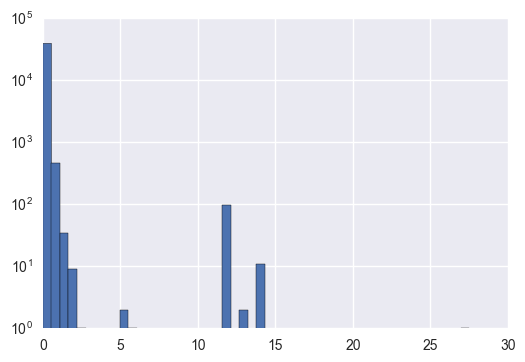

In [7]:
plt.hist(data["DEMAND"].values, bins=50, log=True)
plt.show()

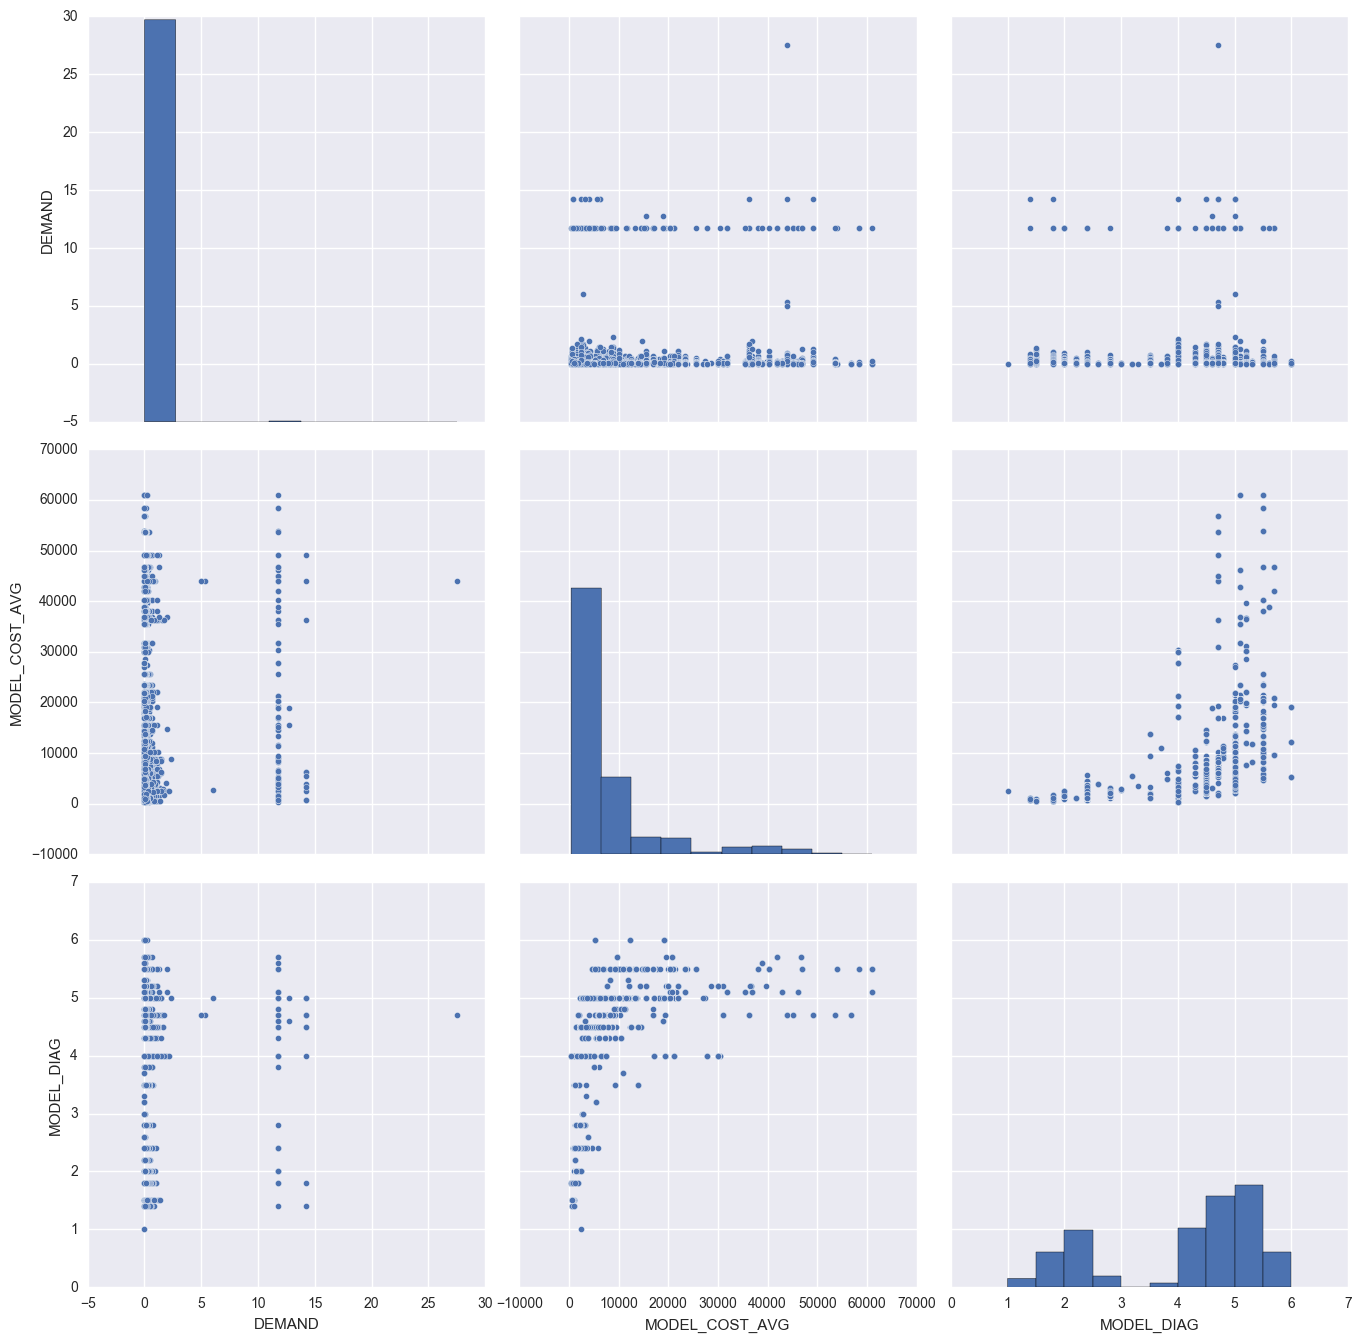

In [8]:
sns.pairplot(data[["DEMAND", "MODEL_COST_AVG", "MODEL_DIAG"]].dropna(), size=4.5)

Дата открытия в не очень хорошем формате, распарсим ее

In [9]:
def parse_date(s):
    date = s.split(":")[0]
    return parser.parse("{} {} {}".format(date[:2], date[2:5], date[5:]))

data["STORE_OPEN_DTTM"] = data["STORE_OPEN_DTTM"].apply(parse_date)

In [10]:
def get_days_from_now(dt):
    return (datetime.now() - dt).days

data["STORE_OPEN_DAYS"] = data["STORE_OPEN_DTTM"].apply(get_days_from_now)

Распарсим также STORE_CLUSTER

In [11]:
def parse_cluster_m(s):
    try:
        return float(s.split("m")[1])
    except:
        return None
    
def parse_cluster_u(s):
    try:
        return float(s.split("m")[0].split("u")[1])
    except:
        return None

data["STORE_CLUSTER_M"] = data["STORE_CLUSTER"].apply(parse_cluster_m)
data["STORE_CLUSTER_U"] = data["STORE_CLUSTER"].apply(parse_cluster_u)

In [12]:
data.head(10)

,DEMAND,LOCATION_ID,MODEL_BRAND,MODEL_COST_AVG,MODEL_COUNT_SALES_DAYS,MODEL_DIAG,MODEL_DIAG_TYPE,MODEL_HEIGHT,MODEL_ID,MODEL_MEAN_SALES,MODEL_NAME,MODEL_OS,MODEL_RES_TYPE,MODEL_TYPE,MODEL_WIDTH,STORE_ASSORTMENT,STORE_BRAND_ABC,STORE_BRAND_SPECTR,STORE_BUILDING_TYPE,STORE_CITY,STORE_CLUSTER,STORE_DIAG_ABC,STORE_DIAG_SPECTR,STORE_FORMAT,STORE_OPEN_DTTM,STORE_PRICE_TYPE,STORE_REGION,STORE_RES_ABC,STORE_RES_SPECTR,STORE_TYPE_A,STORE_TYPE_B,STORE_TYPE_C,STORE_TYPE_SPECTR,STORE_OPEN_DAYS,STORE_CLUSTER_M,STORE_CLUSTER_U
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.105360,1835543262,ark,5179.7500,NaN,5.5,big,720.0,1682,NaN,ark benefit m7,gsm-and,hd,смартфон,1280.0,136.0,A,0.76,торговый центр,санкт-петербург г,u3m3,A,0.78,новый формат,2015-05-19,розничная цена (северо-запад-санкт-петербург),северо-запад,B,0.67,0.75,0.25,0.0,3.06,558,3.0,3.0
1,0.000100,1972241965,samsung,22015.3300,NaN,5.2,big,1920.0,34706,NaN,samsung a510 galaxy a5 (2016 edition),gsm-and,hd,смартфон,1080.0,70.0,B,0.73,павильон,санкт-петербург г,u1m2,B,0.65,новый формат,2016-01-20,розничная цена (северо-запад-днс1),северо-запад,C,0.48,0.00,1.00,0.0,2.51,312,2.0,1.0
2,0.000100,2027986985,samsung,15592.5900,NaN,5.0,big,1280.0,2753,NaN,samsung a5,gsm-and,hd,смартфон,1280.0,106.0,A,0.89,капитальное строение,якутск г,тест,A,0.67,новый формат,2016-04-27,розничная цена (дальний восток-якутск),дальний восток,A,0.64,1.00,0.00,0.0,2.72,214,NaN,NaN
3,0.000100,28432,alcatel,540.9533,29.0,1.8,small,128.0,1593,7.533,alcatel ot1042d,gsm без ос,low,не смартфон,160.0,132.0,B,0.67,капитальное строение,ломоносов г,u3m3,B,0.60,стандарт,2009-10-21,розничная цена (северо-запад-боровичи),северо-запад,B,0.65,0.50,0.25,0.0,2.04,2594,3.0,3.0
4,0.000100,28547,мтс,444.7300,30.0,4.0,medium,480.0,80644,16.830,мтс smart start 2 dual sim lock,gsm-and,low,смартфон,800.0,95.0,A,1.00,павильон,санкт-петербург г,unknown,A,0.71,стандарт,2009-05-20,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.83,0.75,0.25,0.0,2.37,2748,NaN,NaN
5,0.000100,183773,alcatel,1681.5950,30.0,4.0,medium,480.0,1616,26.300,alcatel ot4032d pop c2,gsm-and,low,смартфон,800.0,116.0,B,0.52,капитальное строение,нерюнгри г,u3m4,A,0.71,эконом-new,2011-06-14,розничная цена (дальний восток-якутск),дальний восток,A,0.67,0.50,0.25,0.0,1.91,1993,4.0,3.0
6,0.036368,1876723290,samsung,38130.2200,NaN,5.5,big,2560.0,168722,NaN,samsung g935 galaxy s7 edge 32gb lte,gsm-and,hd,смартфон,1440.0,87.0,A,0.89,капитальное строение,ленск г,u2m3,A,0.73,новый формат,2015-08-05,розничная цена (дальний восток-якутск),дальний восток,A,0.68,1.00,0.00,0.0,3.00,480,3.0,2.0
7,0.081096,1272996680,ark,3546.1150,NaN,5.0,big,480.0,1680,NaN,ark benefit m5 plus dual,gsm-and,low,смартфон,854.0,153.0,A,0.76,торговый центр,санкт-петербург г,u4m4,A,0.70,эконом-new,2013-02-26,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.94,1.00,0.00,0.0,2.99,1370,4.0,4.0
8,0.000100,488028688,alcatel,1511.1900,NaN,2.4,medium,240.0,1598,NaN,alcatel ot2004g (без кредла),gsm без ос,low,не смартфон,320.0,187.0,A,0.53,торговый центр,санкт-петербург г,u4m4,A,0.56,новый формат,2012-05-12,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.66,1.00,0.00,0.0,2.91,1660,4.0,4.0


### Категориальные признаки
#### 1. Какие категориальные признаки следует использовать в первую очередь? 
 
 BRAND, STORE_CLUSTER (но надо распарсить и превратить в числовой, как я и сделал), *_ABC признаки
 
 Может также пригодится STORE_OPEN_DTTM, но его надо превратить в числовой (количество дней, в течении которых был открыт магазин). Это тоже сделано сверху

#### 2. Есть ли категориальные признаки, которые в принципе не понятно, как использовать?
 
 MODEL_NAME, MODEL_ID, LOCATION_ID

In [13]:
# Определяем категориальные признаки
# По понятным причинам 'LOCATION_ID', 'MODEL_ID' считаются числовыми признаками - их добавляем руками отдельно
Categorical_columns = (data.columns[([isinstance(z, str) for z in data.ix[0]])] |
                       data.columns[data.columns == "LOCATION_ID"] |
                       data.columns[data.columns == "MODEL_ID"])
Categorical_columns

Index(['LOCATION_ID', 'MODEL_BRAND', 'MODEL_DIAG_TYPE', 'MODEL_ID',
       'MODEL_NAME', 'MODEL_OS', 'MODEL_RES_TYPE', 'MODEL_TYPE',
       'STORE_BRAND_ABC', 'STORE_BUILDING_TYPE', 'STORE_CITY', 'STORE_CLUSTER',
       'STORE_DIAG_ABC', 'STORE_FORMAT', 'STORE_PRICE_TYPE', 'STORE_REGION',
       'STORE_RES_ABC'],
      dtype='object')

In [14]:
# Количество уникальных значений в категориальных признаках
dist_val = pd.DataFrame({'NoUniqueValues': [data[z].nunique() for z in Categorical_columns]}, index = Categorical_columns)

print('Количество уникальных категориальных значений: '+ str(dist_val.sum().values))
print('Удаляем признаки с номерами: \n'+ str(dist_val.ix[dist_val['NoUniqueValues']>0].sort_values(by='NoUniqueValues', ascending=False)))

Количество уникальных категориальных значений: [1408]
Удаляем признаки с номерами: 
                     NoUniqueValues
MODEL_ID                        447
MODEL_NAME                      447
LOCATION_ID                     362
STORE_CITY                       36
MODEL_BRAND                      33
STORE_CLUSTER                    23
STORE_PRICE_TYPE                 20
STORE_FORMAT                     10
STORE_REGION                      5
MODEL_OS                          5
STORE_DIAG_ABC                    3
STORE_BRAND_ABC                   3
STORE_BUILDING_TYPE               3
MODEL_RES_TYPE                    3
MODEL_DIAG_TYPE                   3
STORE_RES_ABC                     3
MODEL_TYPE                        2


In [15]:
# Запоминаем те категориальные признаки, с которыми будем далее работать (используется далее)

Categorical_columns_use = Categorical_columns[list(set(range(len(Categorical_columns))) - {0, 3, 4, 11})]

In [16]:
# Количество уникальных значений в категориальных признаках
dist_val = pd.DataFrame({'NoUniqueValues': [data[z].nunique() for z in Categorical_columns_use]}, index = Categorical_columns_use)

print('Количество уникальных категориальных значений: '+ str(dist_val.sum().values))
print('Удаляем признаки с номерами: \n'+ str(dist_val.ix[dist_val['NoUniqueValues']>0].sort_values(by='NoUniqueValues', ascending=False)))

Количество уникальных категориальных значений: [129]
Удаляем признаки с номерами: 
                     NoUniqueValues
STORE_CITY                       36
MODEL_BRAND                      33
STORE_PRICE_TYPE                 20
STORE_FORMAT                     10
MODEL_OS                          5
STORE_REGION                      5
MODEL_DIAG_TYPE                   3
MODEL_RES_TYPE                    3
STORE_BRAND_ABC                   3
STORE_BUILDING_TYPE               3
STORE_DIAG_ABC                    3
STORE_RES_ABC                     3
MODEL_TYPE                        2


### Числовые признаки
#### 1. Какие числовые признаки следует использовать в первую очередь? 

MODEL_COST_AVG, *_SPECT, STORE_CLUSTER_M, STORE_CLUSTER_U

#### 2. Есть ли числовые признаки, которые в принципе не понятно, как использовать?

Нет таких

#### 3. Как заполнять NaN?

Для разных значений по разному

In [17]:
# Выделяем числовой датасет: В данном случае удаляем все + MODEL_ID и LOCATION_ID
num_data = data.drop(Categorical_columns | data.columns[[1,8,24]], axis = 1)
num_data.columns

Index(['DEMAND', 'MODEL_COST_AVG', 'MODEL_COUNT_SALES_DAYS', 'MODEL_DIAG',
       'MODEL_HEIGHT', 'MODEL_MEAN_SALES', 'MODEL_WIDTH', 'STORE_ASSORTMENT',
       'STORE_BRAND_SPECTR', 'STORE_DIAG_SPECTR', 'STORE_RES_SPECTR',
       'STORE_TYPE_A', 'STORE_TYPE_B', 'STORE_TYPE_C', 'STORE_TYPE_SPECTR',
       'STORE_OPEN_DAYS', 'STORE_CLUSTER_M', 'STORE_CLUSTER_U'],
      dtype='object')

In [18]:
# Количество NaN в числовых признаках
print('Количество NaN:')
nan_val = num_data.isnull().sum().T
nan_val
# print('Удаляем признаки с номерами: \n'+ str(nan_val.sort_values(by='NoUniqueValues', ascending=False)))

Количество NaN:


DEMAND                        0
MODEL_COST_AVG                0
MODEL_COUNT_SALES_DAYS    18917
MODEL_DIAG                  212
MODEL_HEIGHT                212
MODEL_MEAN_SALES          18917
MODEL_WIDTH                 212
STORE_ASSORTMENT            235
STORE_BRAND_SPECTR          235
STORE_DIAG_SPECTR           442
STORE_RES_SPECTR            446
STORE_TYPE_A                  0
STORE_TYPE_B                  0
STORE_TYPE_C                  0
STORE_TYPE_SPECTR             0
STORE_OPEN_DAYS               0
STORE_CLUSTER_M            9824
STORE_CLUSTER_U            9824
dtype: int64

##### Преобразовываем числовые признаки (удаляем/добавляем/заменяем nan)

In [19]:
# Здесь добавьте код по заполнению NaN
num_data = num_data.fillna(num_data.mean())

In [20]:
num_data.head()

,DEMAND,MODEL_COST_AVG,MODEL_COUNT_SALES_DAYS,MODEL_DIAG,MODEL_HEIGHT,MODEL_MEAN_SALES,MODEL_WIDTH,STORE_ASSORTMENT,STORE_BRAND_SPECTR,STORE_DIAG_SPECTR,STORE_RES_SPECTR,STORE_TYPE_A,STORE_TYPE_B,STORE_TYPE_C,STORE_TYPE_SPECTR,STORE_OPEN_DAYS,STORE_CLUSTER_M,STORE_CLUSTER_U
ID,,,,,,,,,,,,,,,,,,
0,0.10536,5179.7500,19.589764,5.5,720.0,6.144029,1280.0,136.0,0.76,0.78,0.67,0.75,0.25,0.0,3.06,558,3.000000,3.000000
1,0.00010,22015.3300,19.589764,5.2,1920.0,6.144029,1080.0,70.0,0.73,0.65,0.48,0.00,1.00,0.0,2.51,312,2.000000,1.000000
2,0.00010,15592.5900,19.589764,5.0,1280.0,6.144029,1280.0,106.0,0.89,0.67,0.64,1.00,0.00,0.0,2.72,214,2.984491,2.816808
3,0.00010,540.9533,29.000000,1.8,128.0,7.533000,160.0,132.0,0.67,0.60,0.65,0.50,0.25,0.0,2.04,2594,3.000000,3.000000
4,0.00010,444.7300,30.000000,4.0,480.0,16.830000,800.0,95.0,1.00,0.71,0.83,0.75,0.25,0.0,2.37,2748,2.984491,2.816808


## Предсказание без категориальных признаков (1 балл)
### Вспомогательные функции

In [21]:
def smape_loss_func(x, y):
    SymAPE = [ 2*np.abs(x-y)/(np.abs(x)+np.abs(y))] 
    return np.mean(SymAPE)

def get_numerated_data(df, categorical_columns):
    simple_df = deepcopy(df)
    for column in categorical_columns:
        simple_df[column] = pd.Categorical.from_array(simple_df[column]).labels
    
    return simple_df

def get_binarized_data(df, categorical_columns):
    binary_df = deepcopy(df)
    for column in categorical_columns:
        binary_df = pd.concat([binary_df, pd.get_dummies(binary_df[column], prefix=column, prefix_sep=': ')], axis=1)
        del binary_df[column]
    
    return binary_df

def split_to_numpy(df, y_column_name):
    #print df
    #print y_column_name
    data_x = df.drop(y_column_name, axis=1).values.astype(np.float32)
    data_y = df[y_column_name].values.astype(np.float32)
    column_names = df.drop(y_column_name, axis=1).columns
    
    return data_x, data_y, column_names

def split_train_test(df, test_size=0.5, random_state=42, y_column_name='y'):
    X = np.asarray(df.drop(y_column_name, axis=1))
    y = np.asarray(df[y_column_name]).ravel()
    trainX, testX, trainY, testY = cross_validation.train_test_split(X, y, test_size=test_size, random_state=42)
    return trainX, testX, trainY, testY

### Необходимые функции

In [22]:
def show_plot(n_est, res, title="", ylabel="acc"):
    fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][1] for x in n_est], 'ro')
#     ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
#     plt.xlabel("n_estimators")
#     plt.ylabel(ylabel)
#     plt.title("Test result")
#     plt.show()
    
#     fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][0] for x in n_est], 'bo')
    ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
    plt.xlabel("n_estimators")
    plt.ylabel("acc")
    plt.title(title)
    plt.show()

def get_results_dummy_reg(acc=smape_loss_func, verbose=True, strg ='mean', const=None):
    results = dict()
    reg = DummyRegressor(strategy=strg, constant=const)
    reg.fit(trainX, trainY)
    predict = reg.predict(testX)
    results[1] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
    if verbose:
        print("Accuracy: " + str(results[1][1]))
    return results

def get_results_baggind_rsm(n_est, max_samples, max_features, acc=smape_loss_func, verbose=True):
    results = dict()
    for i in n_est:
        reg = BaggingRegressor(n_estimators=i,
                          max_samples=max_samples, max_features=max_features, random_state=1234, n_jobs=-1, verbose=0)
        reg.fit(trainX, trainY)
#         results[i] = (mse(reg.predict(trainX), trainY), mse(reg.predict(testX), testY))
        predict = reg.predict(testX)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_rf(n_est, oob=False, verbose=True, acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = RandomForestRegressor(n_estimators=i, n_jobs=-1, random_state=1234, verbose=0,
                                    oob_score=oob, max_features='sqrt')
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if oob:
            results[i] = (reg.oob_score_, acc(predict, testY))
        else:
            results[i] = (acc(trainY, reg.predict(trainX)), acc(testY,predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_erte(n_est, verbose=True,acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = ExtraTreesRegressor(n_estimators=i, n_jobs=-1, random_state=12, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        results[i] = (acc(trainY,reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_gbdt(n_est, verbose=True, init=None, acc=smape_loss_func, min_max_filter=True, max_val=1, min_val=0.001):
    results = dict()
    for i in n_est:
        if init is not None:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=1234, verbose=0, init=init)
        else:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=1234, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if min_max_filter:
            predict = np.minimum(np.maximum(predict, min_val),max_val)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))    
    return results

def get_optimal(results):
    results = sorted(results, key=lambda x: x[1])

### Делим выборку на обучение и контроль

In [23]:
trainX, testX, trainY, testY = split_train_test(df = num_data, test_size=0.1,  y_column_name='DEMAND')

### DummyRegressor
* Самый простой классификатор на числовых признаках используется как база для сравнения

In [25]:
%time results = get_results_dummy_reg()
%time results = get_results_dummy_reg(strg='constant', const=0.001)

Accuracy: 1.24306344718
CPU times: user 2.72 ms, sys: 1.56 ms, total: 4.28 ms
Wall time: 3.17 ms
Accuracy: 1.81014628129
CPU times: user 1.36 ms, sys: 86 µs, total: 1.45 ms
Wall time: 1.39 ms


### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

** Каким стоит брать размер bootstrap выборки и RSM выборки ** 
Например: 
**Bagging:** 0.5 от размера тестовой выборки.

**RSM:** 0.5 от размера тестовой выборки.

Count of estimators: 10, accuracy: 1.20668117785
Count of estimators: 20, accuracy: 1.21688263785
Count of estimators: 30, accuracy: 1.21682600395
Count of estimators: 40, accuracy: 1.2155622889
Count of estimators: 50, accuracy: 1.21641359762
Count of estimators: 60, accuracy: 1.21508753847
Count of estimators: 70, accuracy: 1.21508582922
Count of estimators: 80, accuracy: 1.21669800301
Count of estimators: 90, accuracy: 1.2193231763
Count of estimators: 100, accuracy: 1.220526743
Count of estimators: 110, accuracy: 1.22131794515
Count of estimators: 120, accuracy: 1.22159716776
Count of estimators: 130, accuracy: 1.22110055747
Count of estimators: 140, accuracy: 1.21940826125
CPU times: user 10.5 s, sys: 13.8 s, total: 24.3 s
Wall time: 1min 29s


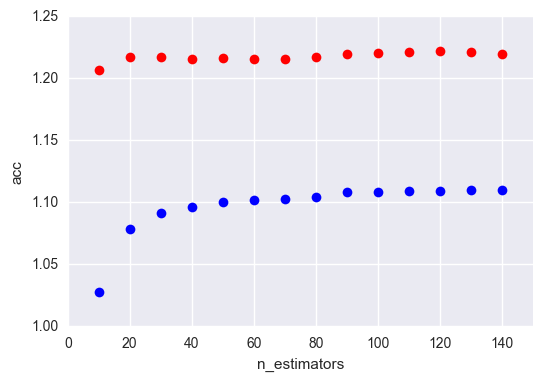

In [26]:
n_est = range(10, 150, 10)
%time results = get_results_baggind_rsm(n_est, 0.5, 0.5, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.17027413449
Count of estimators: 20, accuracy: 1.20489123534
Count of estimators: 30, accuracy: 1.21255024867
Count of estimators: 40, accuracy: 1.21195197267
Count of estimators: 50, accuracy: 1.21525216243
Count of estimators: 60, accuracy: 1.21639760383
Count of estimators: 70, accuracy: 1.21802103454
Count of estimators: 80, accuracy: 1.21819642021
Count of estimators: 90, accuracy: 1.21758763572
Count of estimators: 100, accuracy: 1.21762584431
Count of estimators: 110, accuracy: 1.21773897352
Count of estimators: 120, accuracy: 1.21918670313
Count of estimators: 130, accuracy: 1.21956850029
Count of estimators: 140, accuracy: 1.21937800436
CPU times: user 2min 18s, sys: 3.9 s, total: 2min 22s
Wall time: 49.8 s


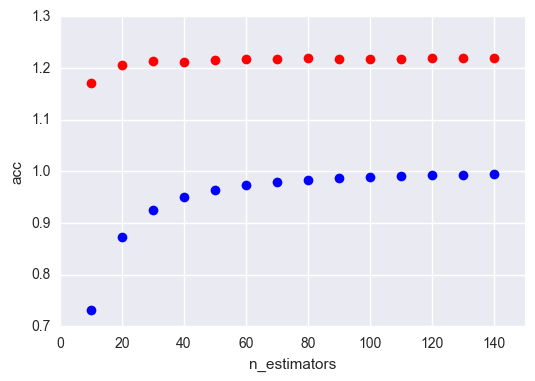

In [27]:
n_est = range(10, 150, 10)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.13236068867
Count of estimators: 20, accuracy: 1.18713066229
Count of estimators: 30, accuracy: 1.20548137639
Count of estimators: 40, accuracy: 1.21023955185
Count of estimators: 50, accuracy: 1.21506036298
Count of estimators: 60, accuracy: 1.21720422876
Count of estimators: 70, accuracy: 1.21892898331
Count of estimators: 80, accuracy: 1.21893405717
Count of estimators: 90, accuracy: 1.21872528858
Count of estimators: 100, accuracy: 1.21884171836
Count of estimators: 110, accuracy: 1.21889395111
Count of estimators: 120, accuracy: 1.219714543
Count of estimators: 130, accuracy: 1.21884010712
Count of estimators: 140, accuracy: 1.21977615603
CPU times: user 3min 55s, sys: 6.58 s, total: 4min 1s
Wall time: 1min 21s


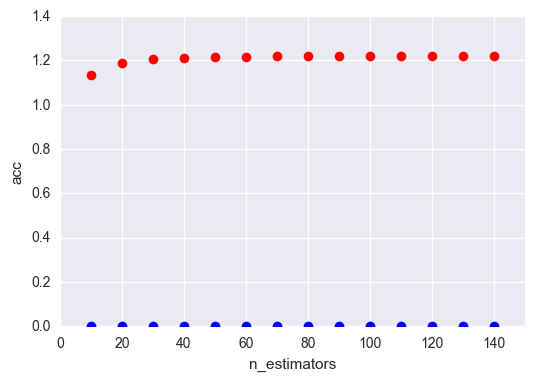

In [29]:
n_est = range(10, 150, 10)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

## Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.22650916601
Count of estimators: 20, accuracy: 1.22188685421
Count of estimators: 30, accuracy: 1.22090287291
Count of estimators: 40, accuracy: 1.22317275249
Count of estimators: 50, accuracy: 1.22217604345
Count of estimators: 60, accuracy: 1.2214808491
Count of estimators: 70, accuracy: 1.22004060235
Count of estimators: 80, accuracy: 1.21745979015
Count of estimators: 90, accuracy: 1.21667421569
Count of estimators: 100, accuracy: 1.21737941598
Count of estimators: 110, accuracy: 1.2173091234
Count of estimators: 120, accuracy: 1.21641682882
Count of estimators: 130, accuracy: 1.2171793577
Count of estimators: 140, accuracy: 1.2169082757
CPU times: user 41.5 s, sys: 404 ms, total: 41.9 s
Wall time: 42.9 s


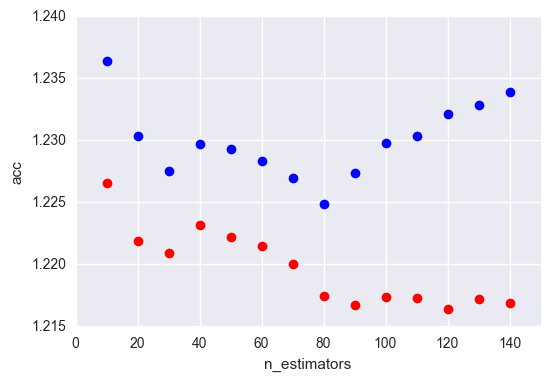

In [30]:
n_est = range(10, 150, 10)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод
Переобучаются ExtraDT, остальные методы показывают результаты на одном уровне (в пределах погрешности).

Для RF и Baggin+RSM оптимальные значения кол-ва близко к 20.

Для GBDT оптимальное количество алгоритмов находится в районе 50.

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**

Все алгоритмы сильно переобучаются, нужно работать над уменьшением разрыва между train и test лоссом, например, добавить регуляризацию, ограничить число деревьев в RandomForest, и т.д.

## Использование категориальных признаков (1 балл)
* Проведите аналогичный экспермент при наличии категориальных признаков

### Обучение и Контроль

In [24]:
Categorical_columns

Index(['LOCATION_ID', 'MODEL_BRAND', 'MODEL_DIAG_TYPE', 'MODEL_ID',
       'MODEL_NAME', 'MODEL_OS', 'MODEL_RES_TYPE', 'MODEL_TYPE',
       'STORE_BRAND_ABC', 'STORE_BUILDING_TYPE', 'STORE_CITY', 'STORE_CLUSTER',
       'STORE_DIAG_ABC', 'STORE_FORMAT', 'STORE_PRICE_TYPE', 'STORE_REGION',
       'STORE_RES_ABC'],
      dtype='object')

In [25]:
# Для обучения используются полезные категориальные признаки
bin_data = get_binarized_data(data, Categorical_columns_use)
print(bin_data.shape)

(40000, 152)


##### Исключаем лишние произнаки, заменяем NaN

In [26]:
bin_data.drop(["STORE_OPEN_DTTM", "MODEL_ID", "LOCATION_ID", "MODEL_NAME", "STORE_CLUSTER"], axis=1, inplace=True)

In [27]:
bin_data = bin_data.fillna(bin_data.mean())

In [28]:
print(1)

1


In [29]:
# Делим выборку на обучение и контроль
trainX, testX, trainY, testY = split_train_test(df = bin_data, test_size=0.1,  y_column_name='DEMAND')

### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 1, accuracy: 0.849119909409
Count of estimators: 2, accuracy: 0.919146902518
Count of estimators: 3, accuracy: 0.985708837983
Count of estimators: 5, accuracy: 1.05862932912
Count of estimators: 10, accuracy: 1.13022572437
Count of estimators: 20, accuracy: 1.1832595791
Count of estimators: 30, accuracy: 1.19271650918
CPU times: user 6.36 s, sys: 2.05 s, total: 8.42 s
Wall time: 45.9 s


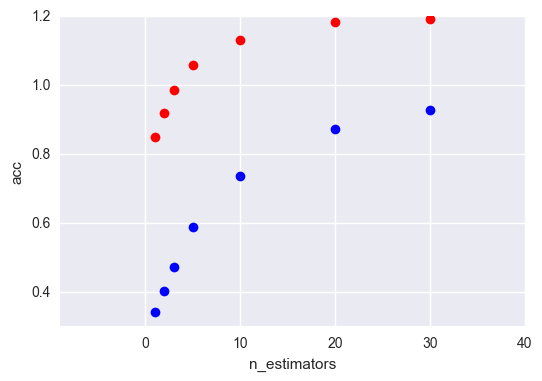

In [62]:
n_est = [1, 2, 3, 5, 10, 20, 30]
%time results = get_results_baggind_rsm(n_est, 0.9, 0.9, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 1, accuracy: 0.913481504288
Count of estimators: 2, accuracy: 0.99490739095
Count of estimators: 3, accuracy: 1.05694184259
Count of estimators: 5, accuracy: 1.11287341571
Count of estimators: 10, accuracy: 1.18091753471
Count of estimators: 20, accuracy: 1.1922309894
Count of estimators: 30, accuracy: 1.19432538444
CPU times: user 13.7 s, sys: 573 ms, total: 14.3 s
Wall time: 7.48 s


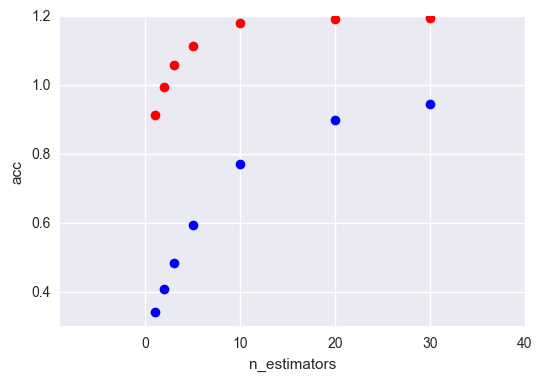

In [63]:
n_est = [1, 2, 3, 5, 10, 20, 30]
%time results = get_results_rf(n_est)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 1, accuracy: 0.852545385692
Count of estimators: 2, accuracy: 0.899428602438
Count of estimators: 3, accuracy: 0.944617498103
Count of estimators: 5, accuracy: 1.01219186982
Count of estimators: 10, accuracy: 1.0800643101
Count of estimators: 20, accuracy: 1.12969325673
Count of estimators: 30, accuracy: 1.14696237549
CPU times: user 2min 13s, sys: 2.15 s, total: 2min 15s
Wall time: 1min 7s


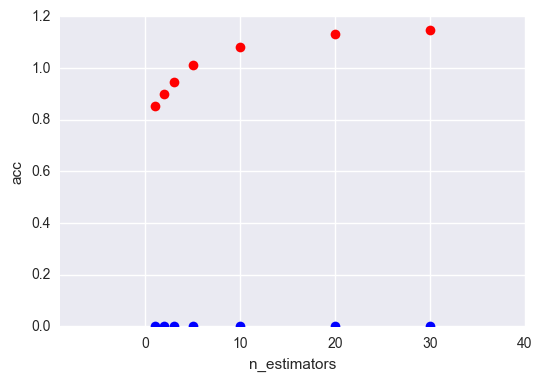

In [64]:
n_est = [1, 2, 3, 5, 10, 20, 30]
%time results = get_results_erte(n_est)
show_plot(n_est, results)

### Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 1, accuracy: 1.23802018584
Count of estimators: 2, accuracy: 1.23450045742
Count of estimators: 3, accuracy: 1.23269832469
Count of estimators: 5, accuracy: 1.22897402639
Count of estimators: 10, accuracy: 1.22243411688
Count of estimators: 20, accuracy: 1.2194966013
Count of estimators: 30, accuracy: 1.21546578559
CPU times: user 25.3 s, sys: 456 ms, total: 25.7 s
Wall time: 27.3 s


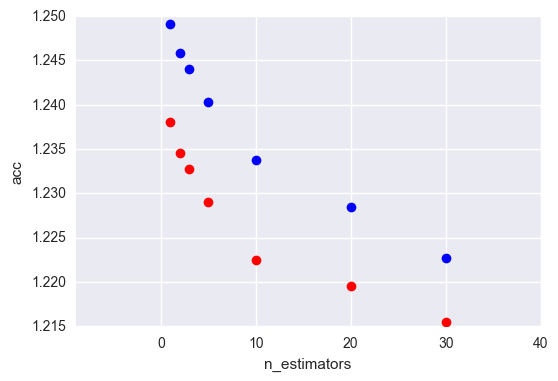

In [65]:
n_est = [1, 2, 3, 5, 10, 20, 30]
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**

С категориальными признаками модели стали работать лучше, но ансамбли не зажгли -- лучшие результаты получает все равно DecisionTreeRegressor. Видимо, ансамбли лучше подходят для задач классификации, а не регрессии.

## Другие модели и генерация дополнительных признаков (2 балла)

* На основании сделанных выводов, предложите другой вариант алгоритма ML, который должен показать лучший результат
* Направляния:
    -- использовать принципиально другое семейство алгоритмов (NN, GB+kNN, LinearRegression, композиция Baggin и GBDT)
    -- исключить бесполезные фичи из обучающей выборки (полезность фич проанализировать с помощью RF);
    -- исключить фичи, в которых есть NaN; сделать восстановление NaN более интеллектуально;
    -- преобразовать катеориальные признаки так, чтобы получились числовые.

In [30]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor

Бейзлайн: DecisionTreeRegressor

In [58]:
reg = DecisionTreeRegressor(max_depth=200)
reg.fit(trainX, trainY)
print("Test loss: {}".format(smape_loss_func(reg.predict(testX), testY)))
print("Train loss: {}".format(smape_loss_func(reg.predict(trainX), trainY)))

Test loss: 0.79046652672977
Train loss: 0.00010826395153148765


Попробуем линейную модель:

In [33]:
reg = LinearRegression()
reg.fit(trainX, trainY)
print("Test loss: {}".format(smape_loss_func(reg.predict(testX), testY)))
print("Train loss: {}".format(smape_loss_func(reg.predict(trainX), trainY)))

/Users/astepanov/.virtualenvs/tf/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Test loss: 1.2972762857350952
Train loss: 1.3064538421476497


Видим, что тест лосс равен трейн лоссу, значит модель не переобучается. Проверим это еще, добавими резуляризацию:

In [34]:
reg = ElasticNet()
reg.fit(trainX, trainY)
print("Test loss: {}".format(smape_loss_func(reg.predict(testX), testY)))
print("Train loss: {}".format(smape_loss_func(reg.predict(trainX), trainY)))

Test loss: 1.2443426437970233
Train loss: 1.2566380781303632


Так и есть. Похоже, линии уровня слишком нелинейны для использования простой линейной регресии. Попробуем SVR с rbf ядром. Но для этого придется оставить только 3000 объектов, чтобы работало быстро

In [39]:
from sklearn.svm import SVR, LinearSVR

In [40]:
reg = SVR()
reg.fit(trainX[:3000], trainY[:3000])
print("Test loss: {}".format(smape_loss_func(reg.predict(testX), testY)))
print("Train loss: {}".format(smape_loss_func(reg.predict(trainX), trainY)))

Test loss: 1.2803302924255604
Train loss: 1.2901011250434717


Попробуем LinearSVR + kernel approximation

In [43]:
from sklearn.kernel_approximation import RBFSampler, Nystroem

In [51]:
approximator = Nystroem(n_components=1000)
new_train_X = approximator.fit_transform(trainX, trainY)
new_test_X = approximator.transform(testX)

In [52]:
reg = LinearSVR()
reg.fit(new_train_X, trainY)
print("Test loss: {}".format(smape_loss_func(reg.predict(new_test_X), testY)))
print("Train loss: {}".format(smape_loss_func(reg.predict(new_train_X), trainY)))

Test loss: 1.2842917015252493
Train loss: 1.265868824013776


In [53]:
approximator = RBFSampler(n_components=1000)
new_train_X = approximator.fit_transform(trainX, trainY)
new_test_X = approximator.transform(testX)

In [54]:
reg = LinearSVR()
reg.fit(new_train_X, trainY)
print("Test loss: {}".format(smape_loss_func(reg.predict(new_test_X), testY)))
print("Train loss: {}".format(smape_loss_func(reg.predict(new_train_X), trainY)))

Test loss: 1.371411090550799
Train loss: 1.348567310168889


Чет тоже не очень. Но Nystroem работает лучше RBFSampler

### Вывод

## Отправка результатов в контест на Kaggle (оценивается по результатам в Leaderboard)

In [74]:
test = pd.read_csv('./data/test.csv', sep=';',decimal= '.', index_col='ID')

test["STORE_OPEN_DTTM"] = test["STORE_OPEN_DTTM"].apply(parse_date)
test["STORE_OPEN_DAYS"] = test["STORE_OPEN_DTTM"].apply(get_days_from_now)
test["STORE_CLUSTER_M"] = test["STORE_CLUSTER"].apply(parse_cluster_m)
test["STORE_CLUSTER_U"] = test["STORE_CLUSTER"].apply(parse_cluster_u)

In [75]:
# Предобработка тестовой выборки (добавляем\удаляем признаки, предобработка NaN и пр.)
test_data = get_binarized_data(test, Categorical_columns_use)

In [76]:
# Все отсутствующие в тестовой выборке столбцы полагаем 0
add_columns = bin_data.columns[1:].difference(test_data.columns)
test_data = pd.merge(test_data, bin_data.ix[test_data.index][add_columns], how='inner', left_index=True, right_index=True)
test_data[add_columns]=0

# Оставляем только столбцы обучающей выборки (целевая переменная в обучающей выборке отсутствует)
test_data = test_data[bin_data.columns[1:]]

test_data = test_data.fillna(bin_data[bin_data.columns[1:]].mean(), inplace=True)

In [77]:
# Обучающая выборка
trainX, _, trainY, _ = split_train_test(df = bin_data, test_size=0,  y_column_name='DEMAND')

In [78]:
# Обучаем финальный алгоритм
final_regressor = DecisionTreeRegressor()
final_regressor.fit(trainX, trainY)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [79]:
# Предсказание интенсивности
test_predict = final_regressor.predict(np.asarray(test_data))

In [80]:
# Сохраняем в csv-файл
test['DEMAND'] = test_predict
test[['DEMAND']].to_csv('./data/submission_gbdt.csv', sep = ',', index = True)